# 1. Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB3

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 2. Load Data

In [2]:
def train_df(tr_path):
    classes = []
    class_paths = []
    files = os.listdir(tr_path)
    for file in files:
        label_dir = os.path.join(tr_path, file)
        label = os.listdir(label_dir)
        for image in label:
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            classes.append(file)
    image_classes = pd.Series(classes, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    tr_df = pd.concat([image_paths, image_classes], axis=1)
    return tr_df

In [3]:
tr_df = train_df('/kaggle/input/sentiment-images-classifier/Sentiment classifier')

In [4]:
tr_df

,Class Path,Class
0,/kaggle/input/sentiment-images-classifier/Sent...,sad
1,/kaggle/input/sentiment-images-classifier/Sent...,sad
2,/kaggle/input/sentiment-images-classifier/Sent...,sad
3,/kaggle/input/sentiment-images-classifier/Sent...,sad
4,/kaggle/input/sentiment-images-classifier/Sent...,sad
...,...,...
1377,/kaggle/input/sentiment-images-classifier/Sent...,happy
1378,/kaggle/input/sentiment-images-classifier/Sent...,happy
1379,/kaggle/input/sentiment-images-classifier/Sent...,happy
1380,/kaggle/input/sentiment-images-classifier/Sent...,happy


# 3. Split data into train, test and valid.

In [5]:
tr_df, ts_df = train_test_split(tr_df,  train_size= 0.8, shuffle= True, random_state= 20)
valid_df, ts_df = train_test_split(ts_df,  train_size= 0.5, shuffle= True, random_state= 20)

In [6]:
valid_df

,Class Path,Class
328,/kaggle/input/sentiment-images-classifier/Sent...,sad
968,/kaggle/input/sentiment-images-classifier/Sent...,happy
36,/kaggle/input/sentiment-images-classifier/Sent...,sad
952,/kaggle/input/sentiment-images-classifier/Sent...,happy
849,/kaggle/input/sentiment-images-classifier/Sent...,happy
...,...,...
285,/kaggle/input/sentiment-images-classifier/Sent...,sad
1080,/kaggle/input/sentiment-images-classifier/Sent...,happy
381,/kaggle/input/sentiment-images-classifier/Sent...,sad
1249,/kaggle/input/sentiment-images-classifier/Sent...,happy


# 4. Preprocessing

In [7]:
batch_size = 16
img_size = (256, 256)
channels = 3
img_shape = (256, 256, 3)

gen = ImageDataGenerator()

tr_gen = gen.flow_from_dataframe(tr_df, x_col= 'Class Path',
                                 y_col= 'Class', target_size= img_size,
                                 color_mode= 'rgb', shuffle= True,
                                 batch_size= batch_size)

valid_gen = gen.flow_from_dataframe(valid_df, x_col= 'Class Path',
                                    y_col= 'Class', target_size= img_size,
                                    color_mode= 'rgb', shuffle= True,
                                    batch_size= batch_size)

ts_gen = gen.flow_from_dataframe(ts_df, x_col= 'Class Path',
                                 y_col= 'Class', target_size= img_size,
                                 color_mode= 'rgb', shuffle= False,
                                 batch_size= batch_size)

Found 1105 validated image filenames belonging to 2 classes.
Found 138 validated image filenames belonging to 2 classes.
Found 139 validated image filenames belonging to 2 classes.


## 4.1 Show sampels from traning data.

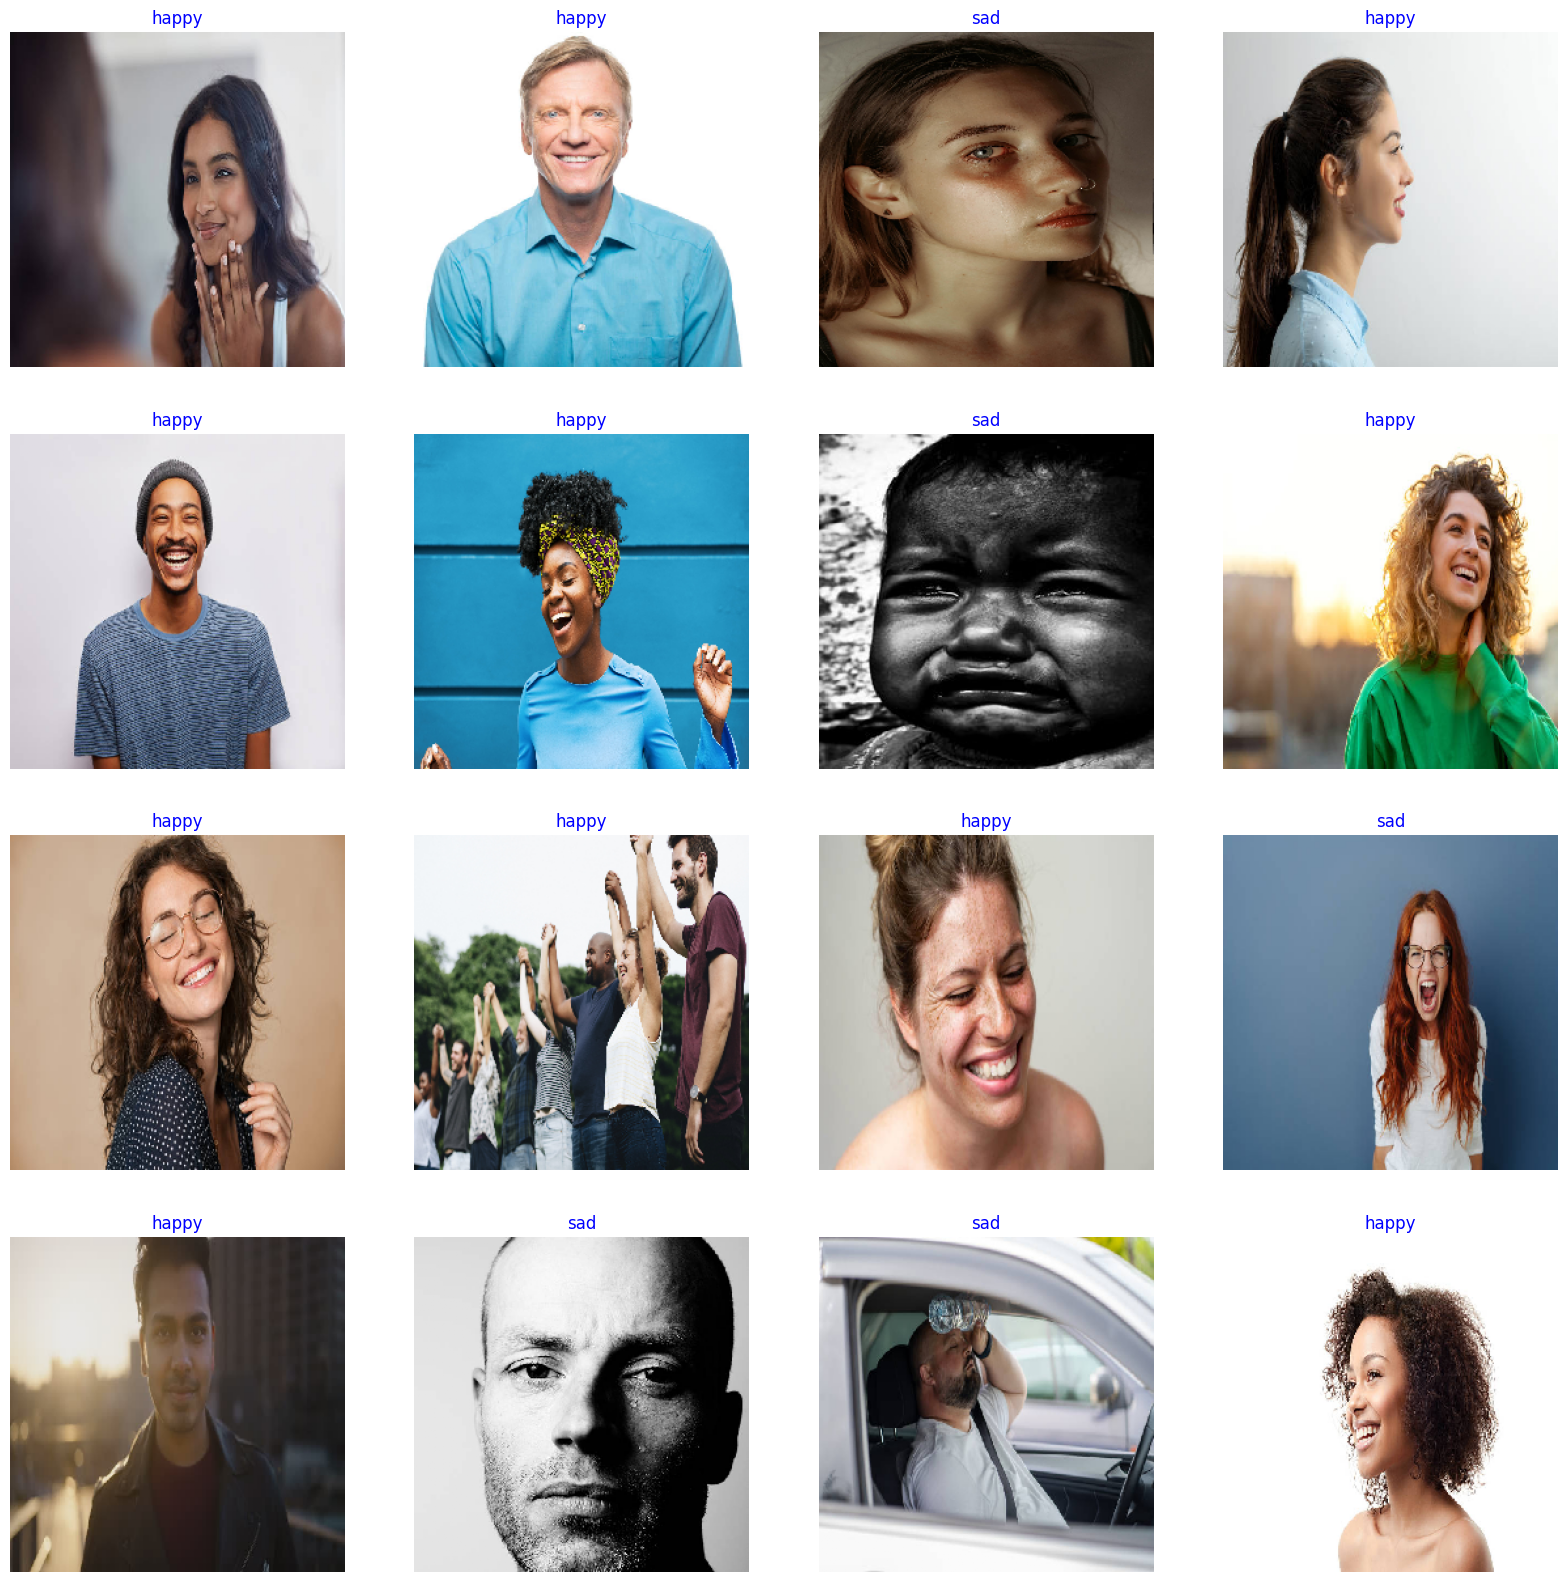

In [8]:
g_dict = tr_gen.class_indices      
classes = list(g_dict.keys())       
images, labels = next(tr_gen) 

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# 5. Build Deep Learning Model

In [9]:
base_model = EfficientNetB3(include_top=False, weights="imagenet",
                      input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    Dense(256,activation= 'relu'),
    Dropout(rate= 0.40, seed= 20),
    Dense(2, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

43941136/43941136 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 11,177,521
Trainable params: 11,090,218
Non-trainable params: 87,303
_________________________________________________________________


# 6. Train

In [10]:
logdir='logs'

In [11]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [12]:
hist = model.fit(tr_gen, epochs=50, validation_data=valid_gen, callbacks=[tensorboard_callback])

Epoch 1/50


2023-10-29 04:48:55.440026: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


70/70 [==============================] - 92s 327ms/step - loss: 1.7207 - accuracy: 0.7059 - val_loss: 0.3873 - val_accuracy: 0.8188
Epoch 2/50
70/70 [==============================] - 19s 271ms/step - loss: 0.2927 - accuracy: 0.8869 - val_loss: 0.2678 - val_accuracy: 0.8696
Epoch 3/50
70/70 [==============================] - 19s 270ms/step - loss: 0.1393 - accuracy: 0.9439 - val_loss: 0.2584 - val_accuracy: 0.8696
Epoch 4/50
70/70 [==============================] - 19s 268ms/step - loss: 0.1504 - accuracy: 0.9439 - val_loss: 0.2767 - val_accuracy: 0.8913
Epoch 5/50
70/70 [==============================] - 19s 269ms/step - loss: 0.0709 - accuracy: 0.9756 - val_loss: 0.2871 - val_accuracy: 0.8768
Epoch 6/50
70/70 [==============================] - 19s 271ms/step - loss: 0.0455 - accuracy: 0.9846 - val_loss: 0.4115 - val_accuracy: 0.8768
Epoch 7/50
70/70 [==============================] - 19s 270ms/step - loss: 0.0465 - accuracy: 0.9810 - val_loss: 0.2679 - val_accuracy: 0.9058
Epoch 8/50

# 7. Plot Performance

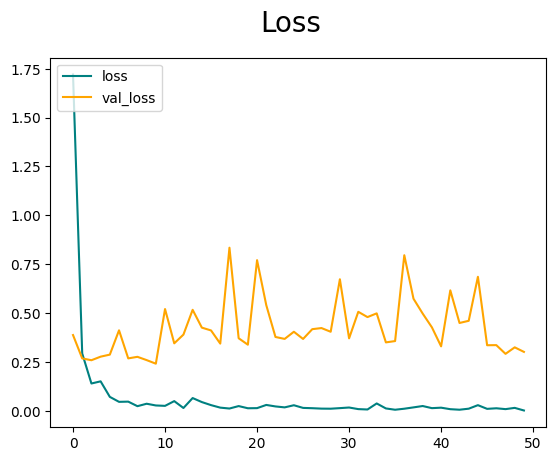

In [13]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

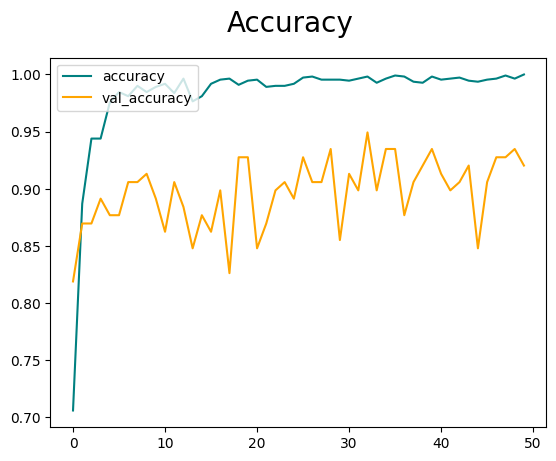

In [14]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 8. Evaluate

In [15]:
train_score = model.evaluate(tr_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(ts_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

9/9 [==============================] - 2s 211ms/step - loss: 0.5457 - accuracy: 0.9281
Train Loss:  2.8504808142315596e-05
Train Accuracy:  1.0
--------------------
Validation Loss:  0.3011004626750946
Validation Accuracy:  0.9202898740768433
--------------------
Test Loss:  0.5457413196563721
Test Accuracy:  0.9280575513839722


In [16]:
preds = model.predict_generator(ts_gen)
y_pred = np.argmax(preds, axis=1)

In [17]:
print(classification_report(ts_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

       happy       0.94      0.94      0.94        85
         sad       0.91      0.91      0.91        54

    accuracy                           0.93       139
   macro avg       0.92      0.92      0.92       139
weighted avg       0.93      0.93      0.93       139



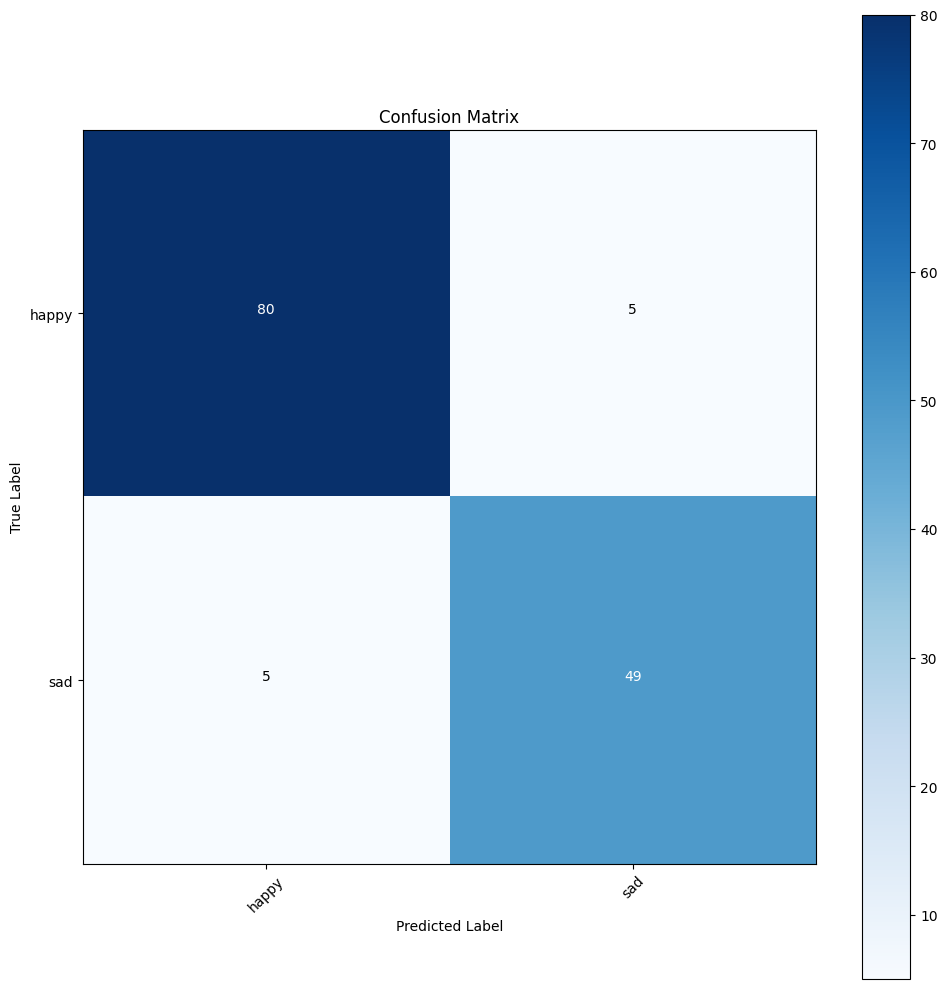

In [18]:
g_dict = ts_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(ts_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()